In [5]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

path = str(Path(Path('thermo.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import scipy
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from tools.cbook import pickle2Obj
import tools
from tools.FV3_tools import read_solo_fields
from tools.CM1_tools import read_cm1_fields

from pltbook import nice_clevels, nice_mxmnintvl, container, plot_contour_row, find_max_index_ND

import matplotlib.colors as mcolors

cmap_data = [(1.0, 1.0, 1.0),
         (0.3137255012989044, 0.8156862854957581, 0.8156862854957581),
         (0.0, 1.0, 1.0),
         (0.0, 0.8784313797950745, 0.501960813999176),
         (0.0, 0.7529411911964417, 0.0),
         (0.501960813999176, 0.8784313797950745, 0.0),
         (1.0, 1.0, 0.0),
         (1.0, 0.6274510025978088, 0.0),
         (1.0, 0.0, 0.0),
         (1.0, 0.125490203499794, 0.501960813999176),
         (0.9411764740943909, 0.250980406999588, 1.0),
         (0.501960813999176, 0.125490203499794, 1.0),
         (0.250980406999588, 0.250980406999588, 1.0),
         (0.125490203499794, 0.125490203499794, 0.501960813999176),
         (0.125490203499794, 0.125490203499794, 0.125490203499794),
         (0.501960813999176, 0.501960813999176, 0.501960813999176),
         (0.8784313797950745, 0.8784313797950745, 0.8784313797950745),
         (0.9333333373069763, 0.8313725590705872, 0.7372549176216125),
         (0.8549019694328308, 0.6509804129600525, 0.47058823704719543),
         (0.6274510025978088, 0.42352941632270813, 0.23529411852359772),
         (0.4000000059604645, 0.20000000298023224, 0.0)]

_nthreads = 2

# draw filled contours.
wclevs = [0, 1, 2.5, 5, 7.5, 10, 15, 20, 30, 40, 50, 60, 70]

tclevs = list(-40.0 + 2*np.arange(41))

pclevs = list(100*(-15.0 + np.arange(31)))

dclevs = list(-20.0 + np.arange(41))

zlevels = 10.0 + 100.*np.arange(150)

zlevels = 20.0 + 80.*np.arange(201)

raw_cape = {"QV12": [915., 1430., 978.],
            "QV13": [1364.4, 1904., 1437.0],
            "QV14": [1872.2, 2354.1, 1953.3],
            "QV15": [2427.5, 2800.2, 2514.6], 
            "QV16": [ 3007.0, 3289.6,  3096.1] }

plotlabels = ["QV12", "QV14", "QV16"]

plotlabels = ["QV15"]

cape_mean = []

def geomean(cape):
    return (cape[0] * cape[1] * cape[2])**(1./3.)

for key in raw_cape:
    cape_mean.append(geomean(raw_cape[key]))

w_ideal = np.sqrt(2.0*np.array(cape_mean))

print(w_ideal)
print(cape_mean)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[46.59768368 55.70051812 64.02349047 71.77687254 79.10372129]
[1085.672061987397, 1551.273859658991, 2049.503665750544, 2575.9597158272036, 3128.6993610705954]


In [55]:
solo = '/work/wicker/climate_runs/FV3_Solo/bubble/euler/3km/QV15'
cm1  = '/work/wicker/climate_runs/cm1r20.3/run/bubble/3km/QV15'
rk2  = '/work/wicker/climate_runs/FV3_Solo/bubble/rk2/3km/QV15'
models = {}

models['cm1']  = ( read_cm1_fields(cm1,  vars = ['pert_th', 'pert_p', 'w'],  zinterp=zlevels, file_pattern=None, ret_dbz=False, ret_ds=False) )
models['solo'] = ( read_solo_fields(solo, vars = ['pert_th', 'theta_IC', 'w', 'pert_p'], zinterp=zlevels, file_pattern=None, ret_dbz=False, ret_ds=False) )
models['rk2'] = ( read_solo_fields(rk2, vars = ['pert_th', 'theta_IC', 'w', 'pert_p'], zinterp=zlevels, file_pattern=None, ret_dbz=False, ret_ds=False) )



------------------------------------------------------------------------------------------------------------------------
 Now Reading:  /work/wicker/climate_runs/cm1r20.3/run/bubble/3km/QV15/cm1out.nc
 Completed reading in:  /work/wicker/climate_runs/cm1r20.3/run/bubble/3km/QV15/cm1out.nc

 Interpolating fields to single column z-grid: /work/wicker/climate_runs/cm1r20.3/run/bubble/3km/QV15/cm1out.nc 

 Finished interp fields to single column z-grid:  /work/wicker/climate_runs/cm1r20.3/run/bubble/3km/QV15 

------------------------------------------------------------------------------------------------------------------------
 Now Reading:  /work/wicker/climate_runs/FV3_Solo/bubble/euler/3km/QV15/atmos_hifreq.nc


ValueError: cannot reshape array of size 12800 into shape (64,64,50)

In [37]:
print(models['cm1']['pert_p'].max(),models['cm1']['pert_p'].min() )
print(models['solo']['pert_p'].max(),models['cm1']['pert_p'].min() )
print(models['solo']['w'].shape)

334.1812 -110.75298
981.8739 -110.75298
(60, 300, 64, 64)


### Find width of updrafts

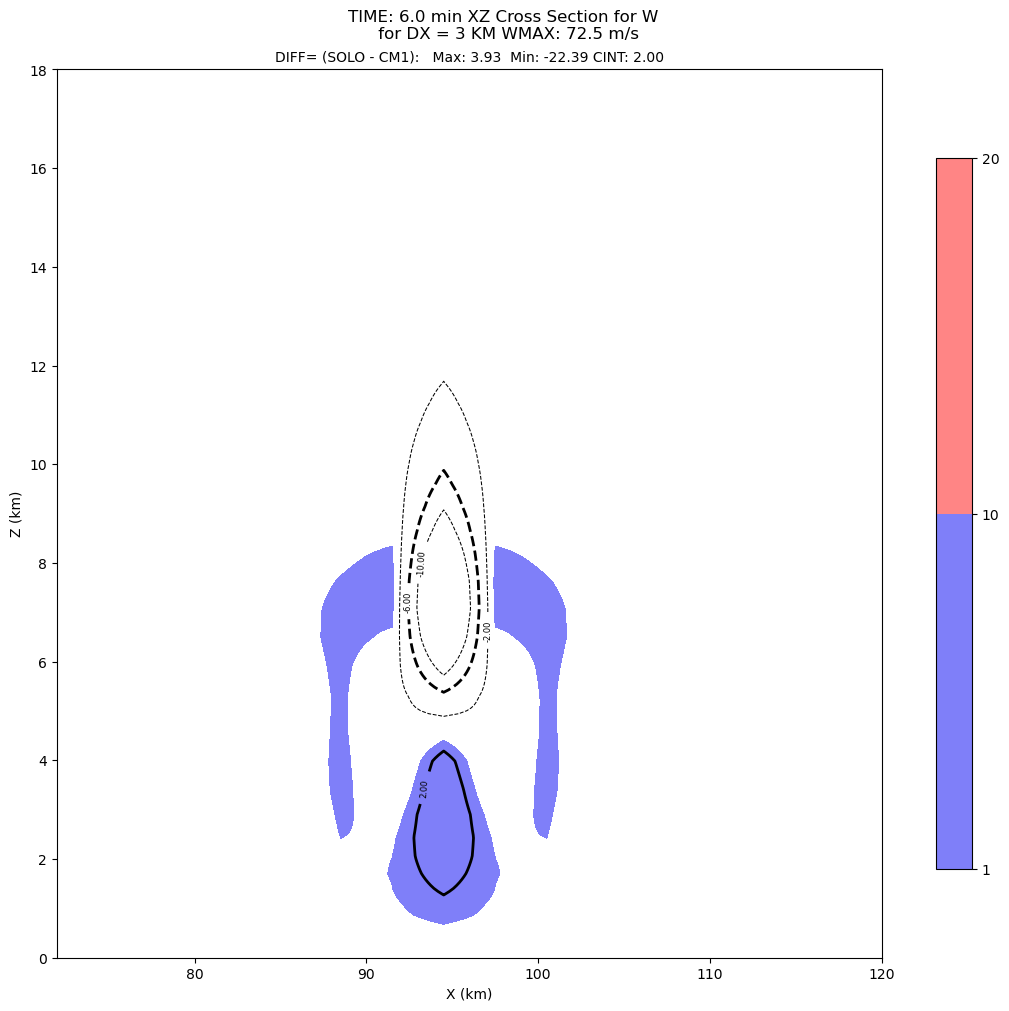

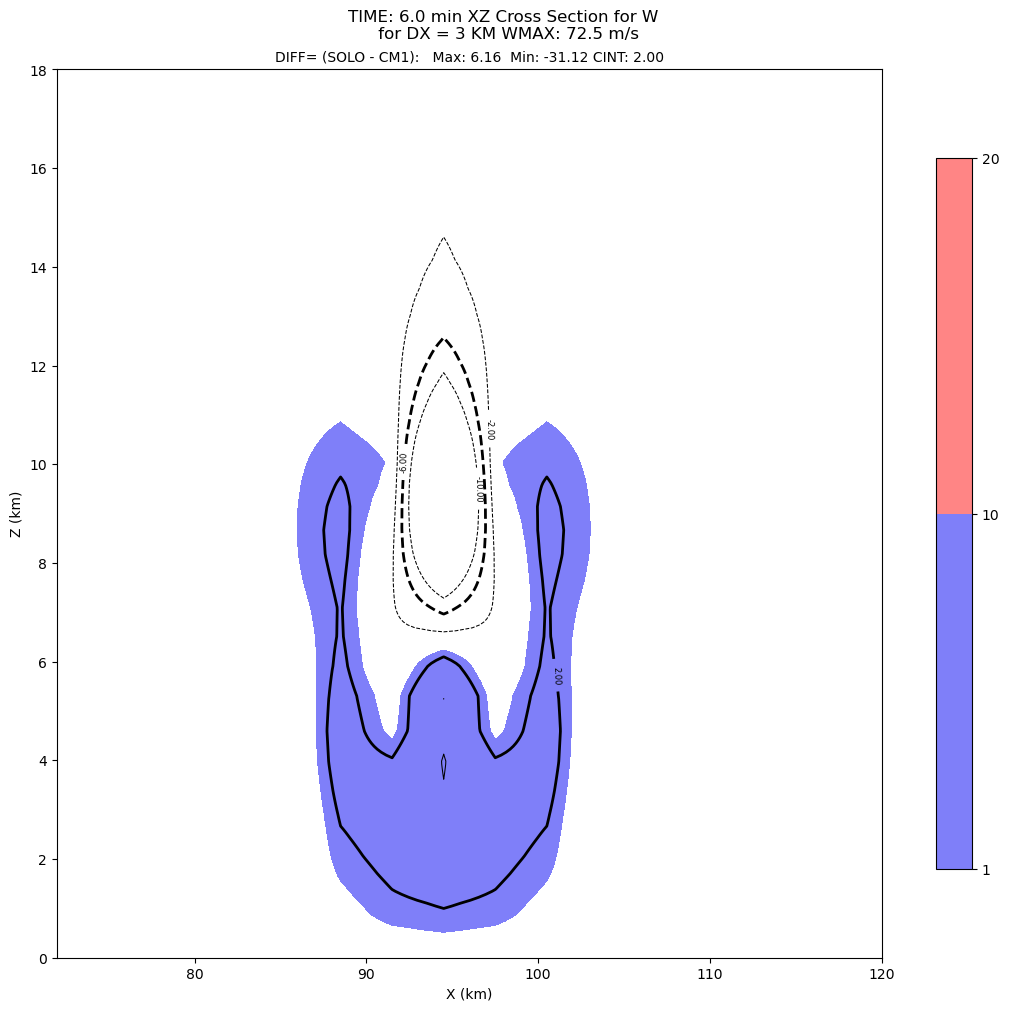

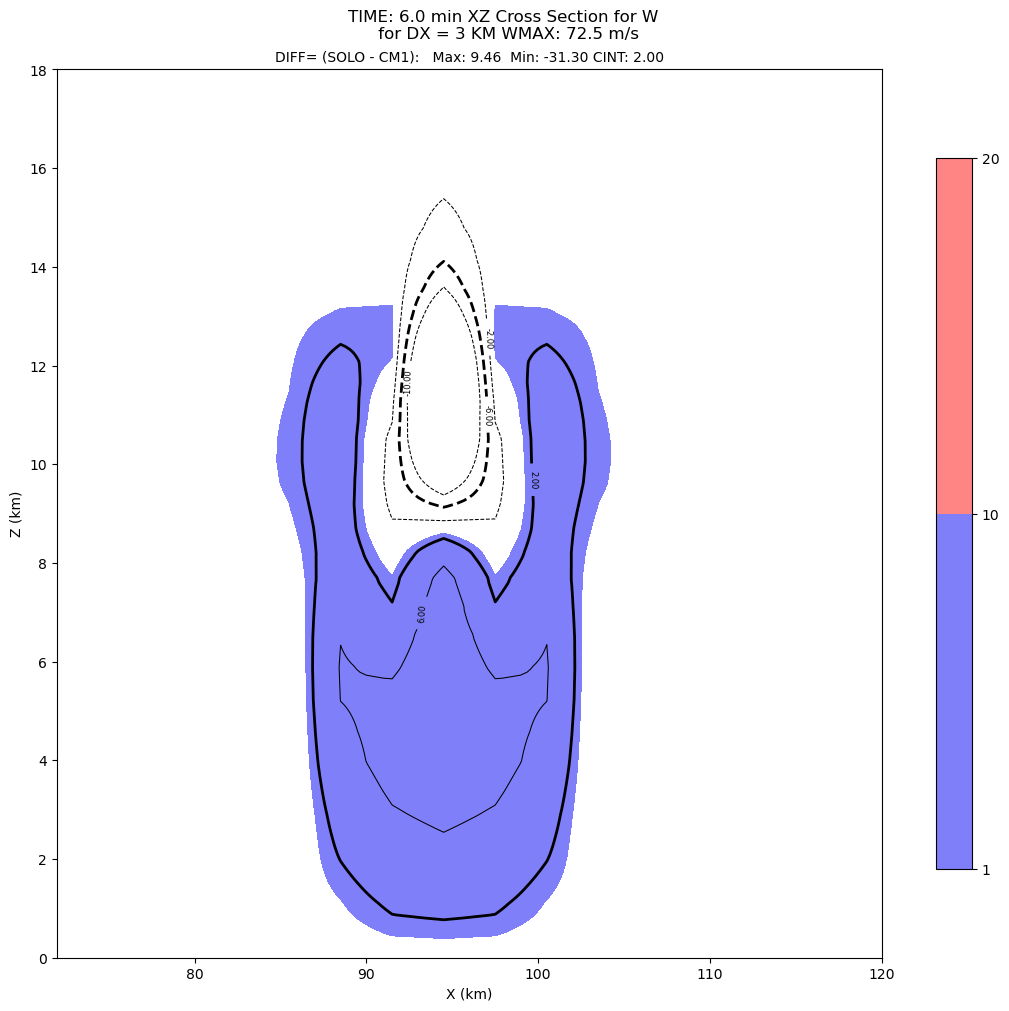

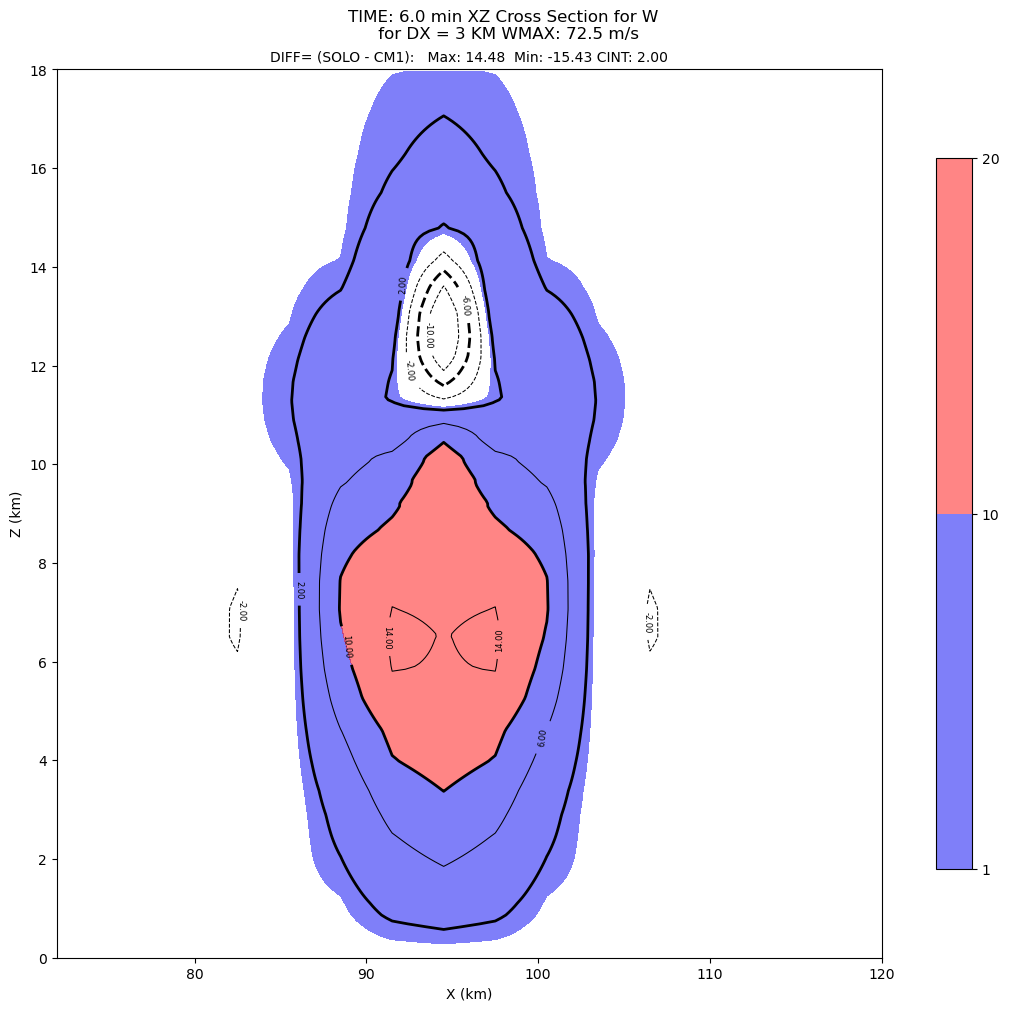

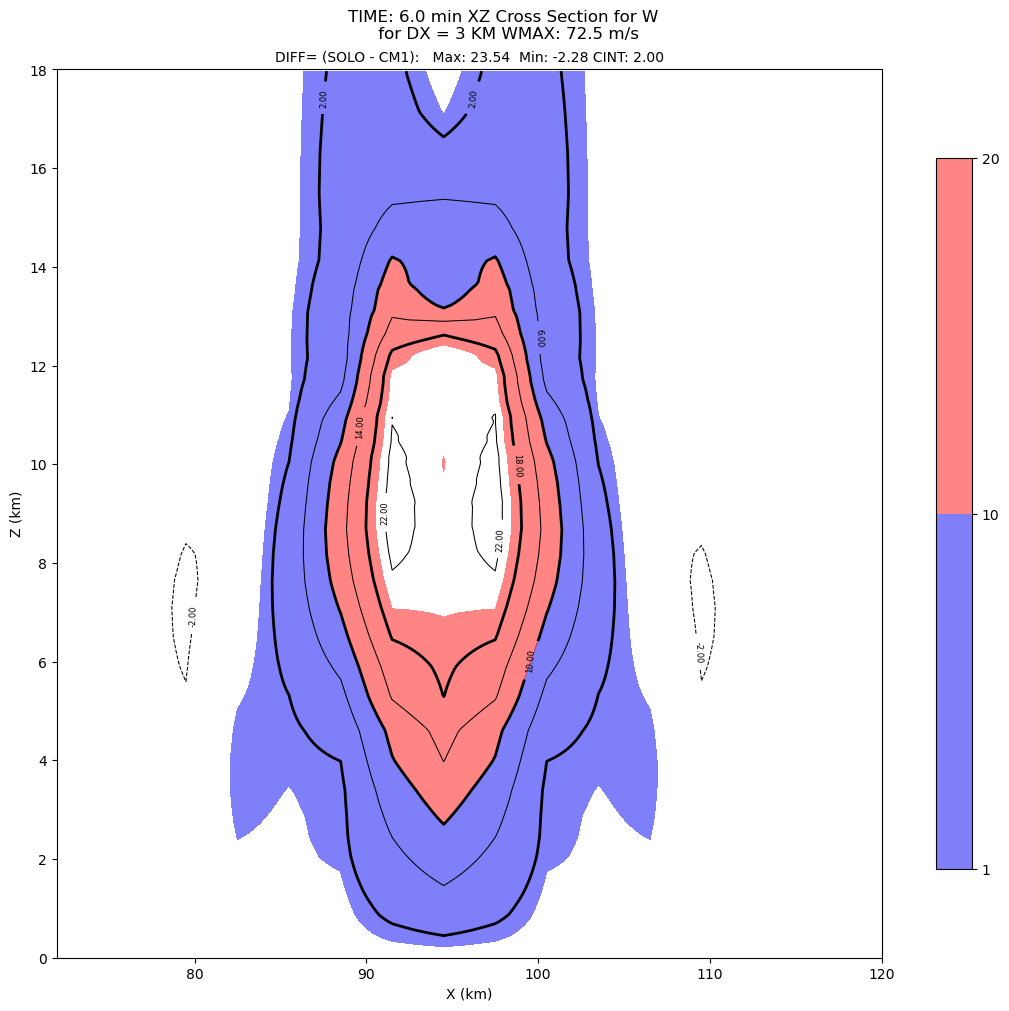

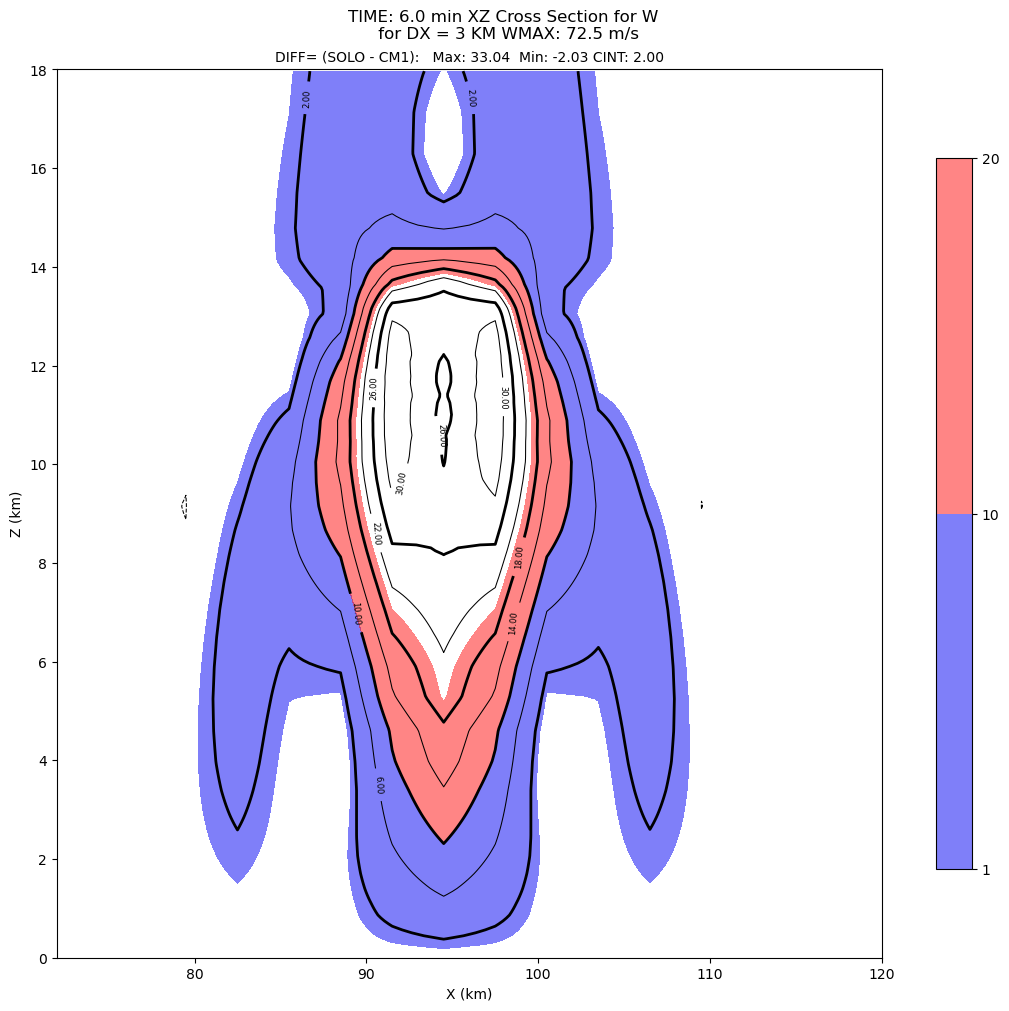

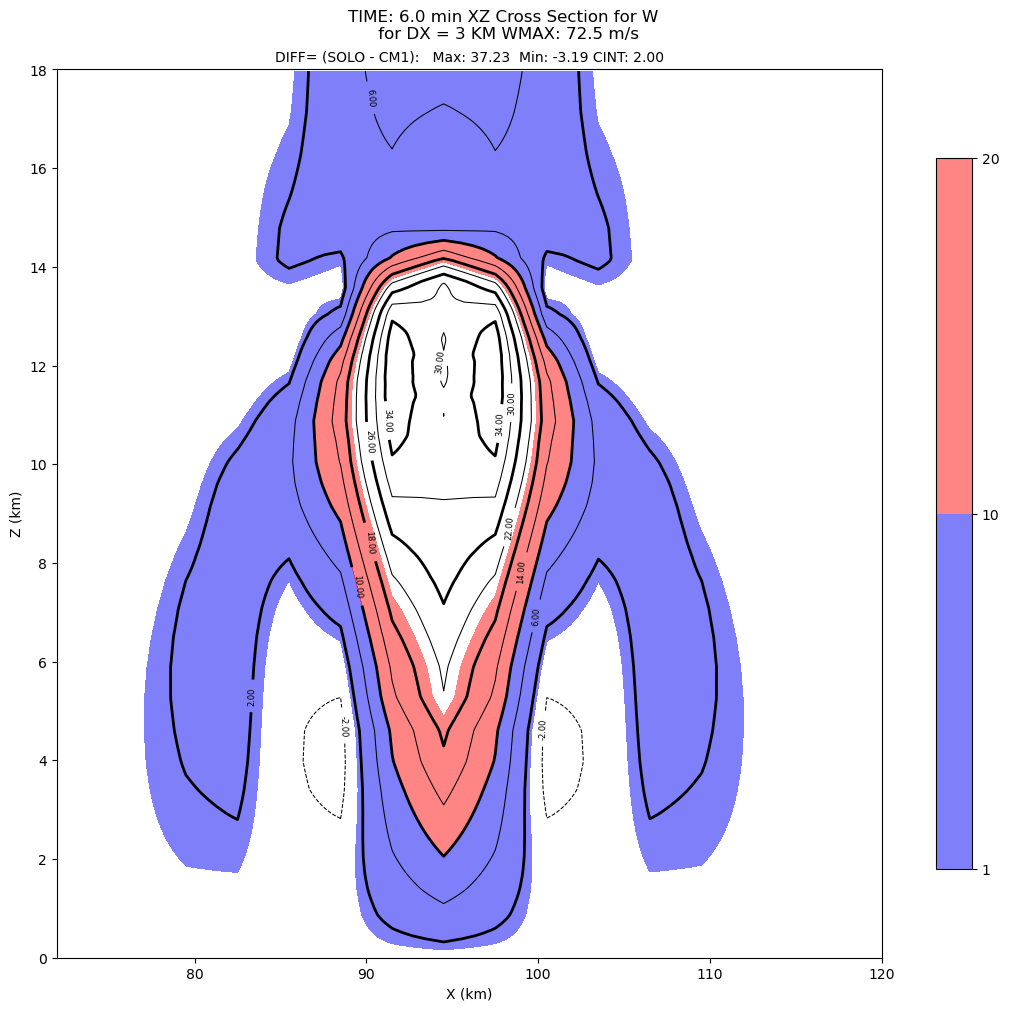

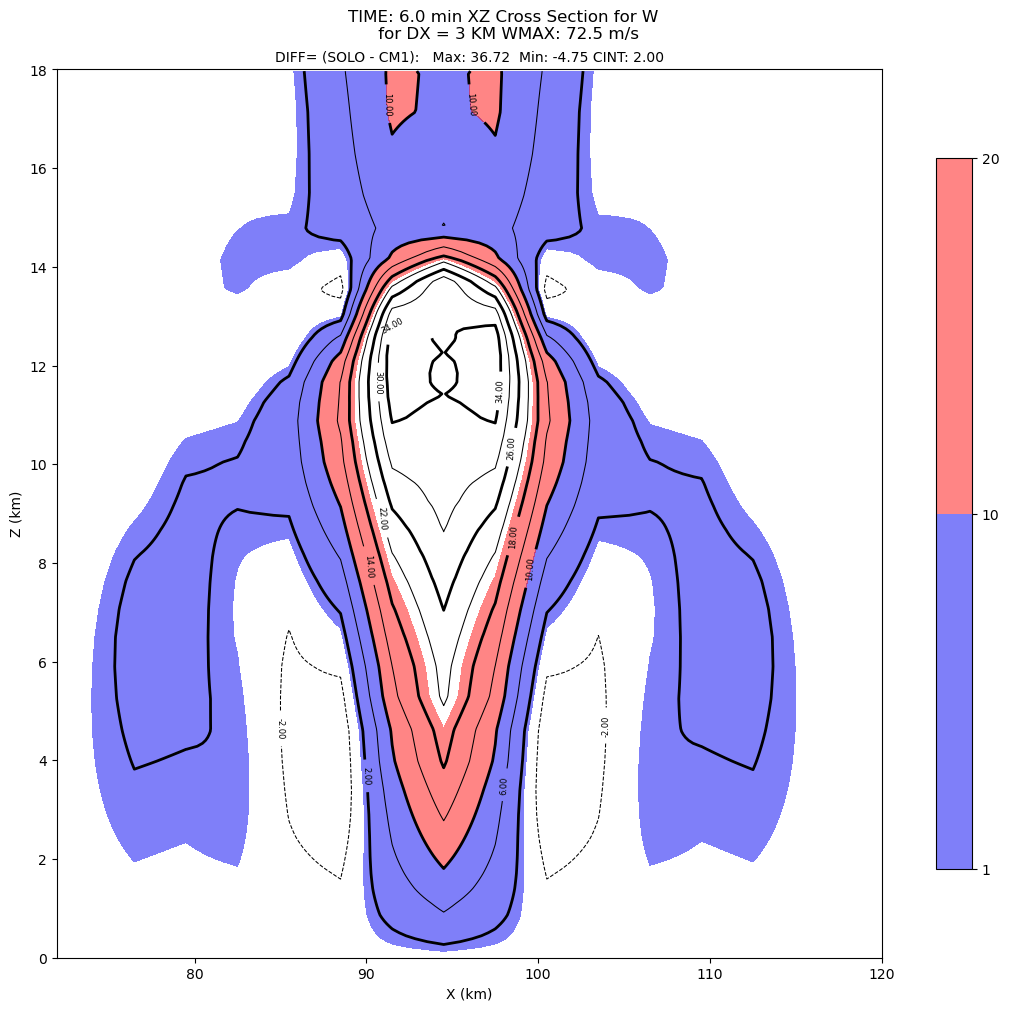

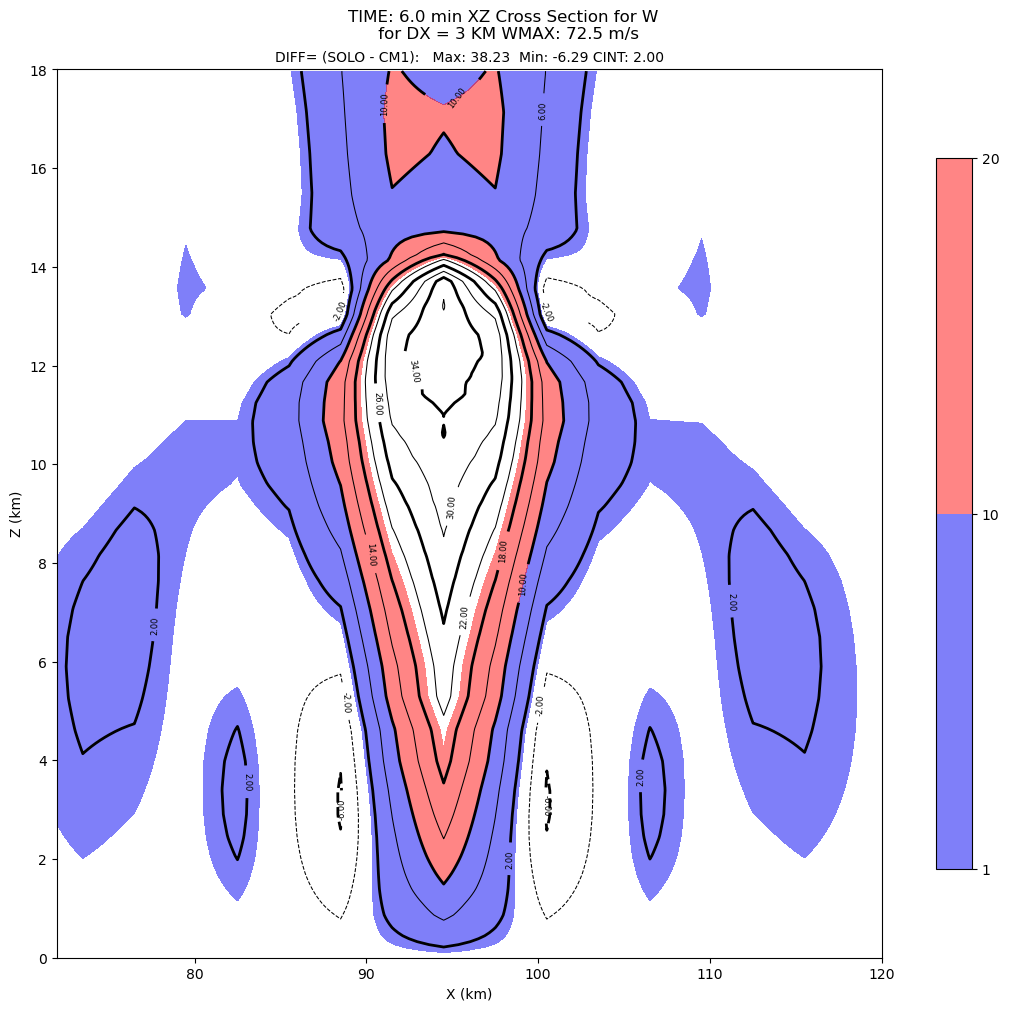

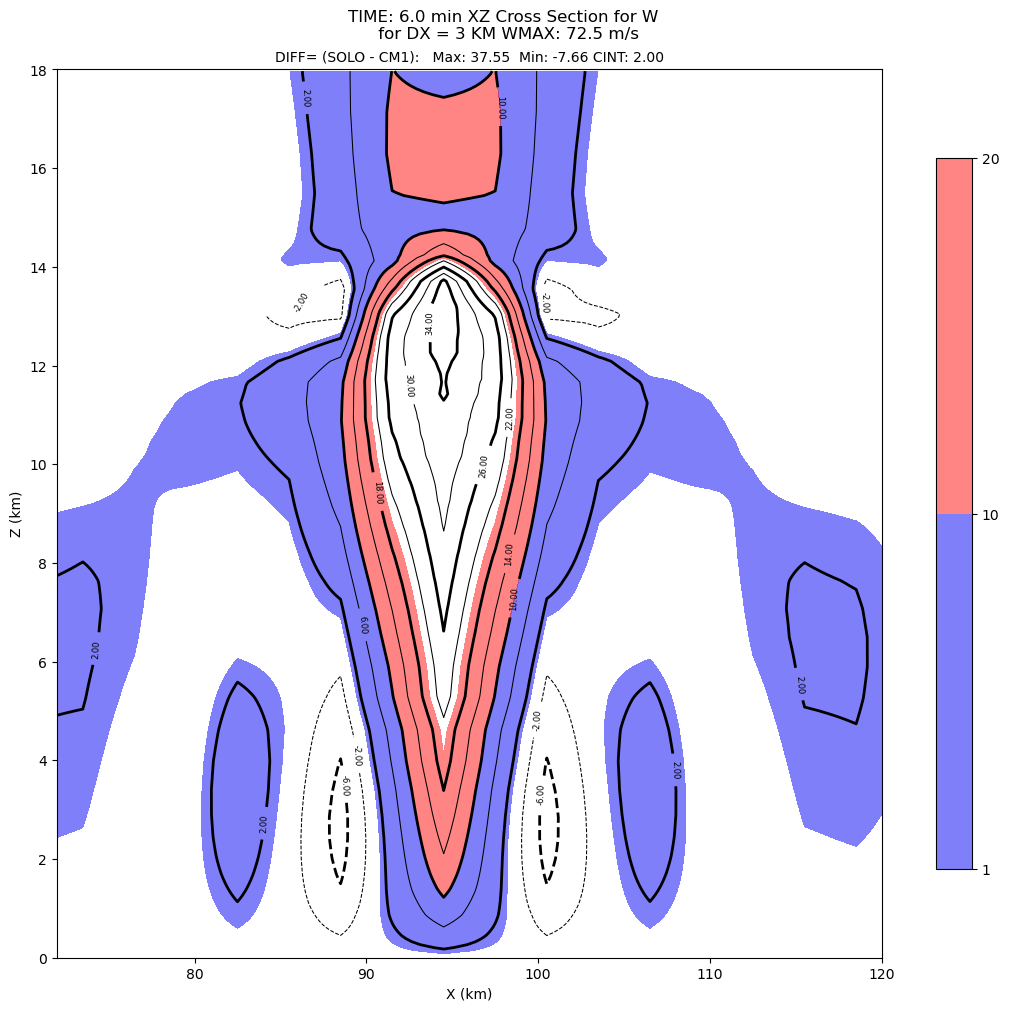

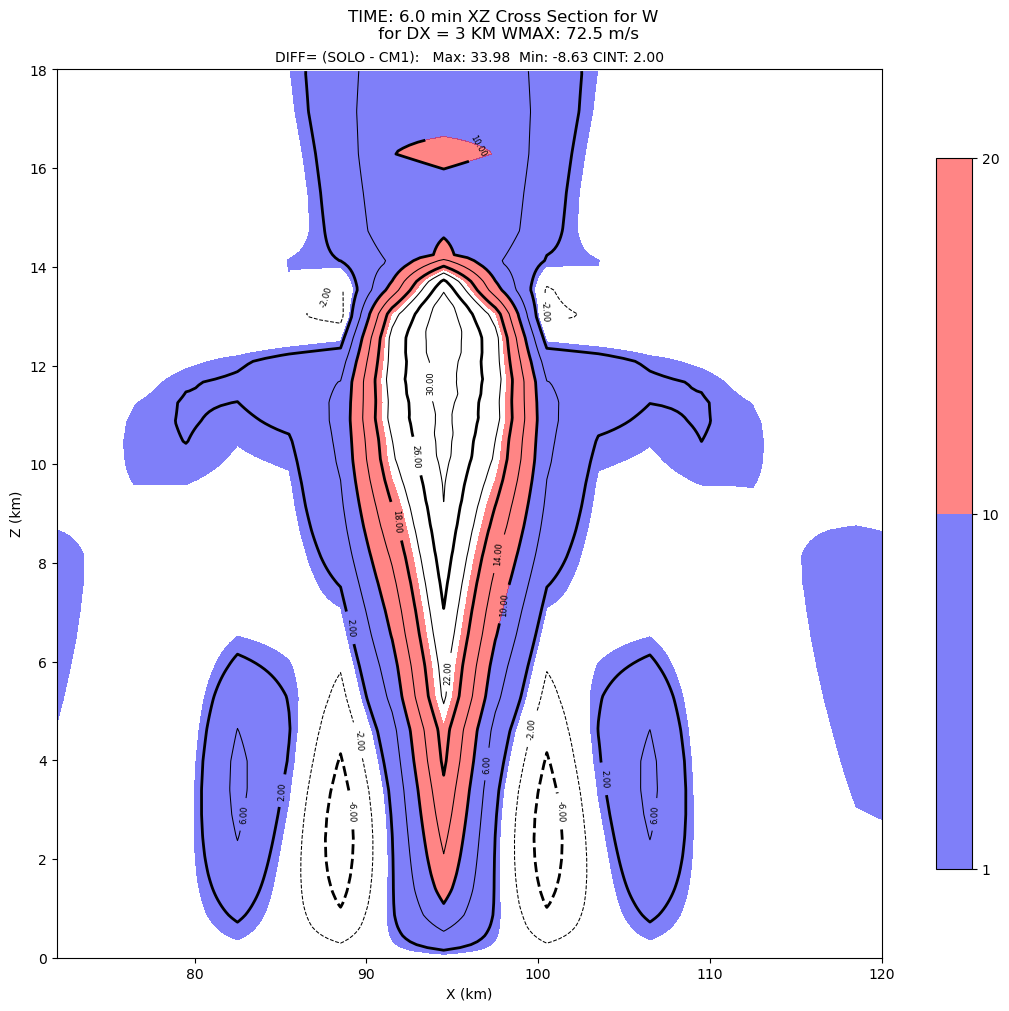

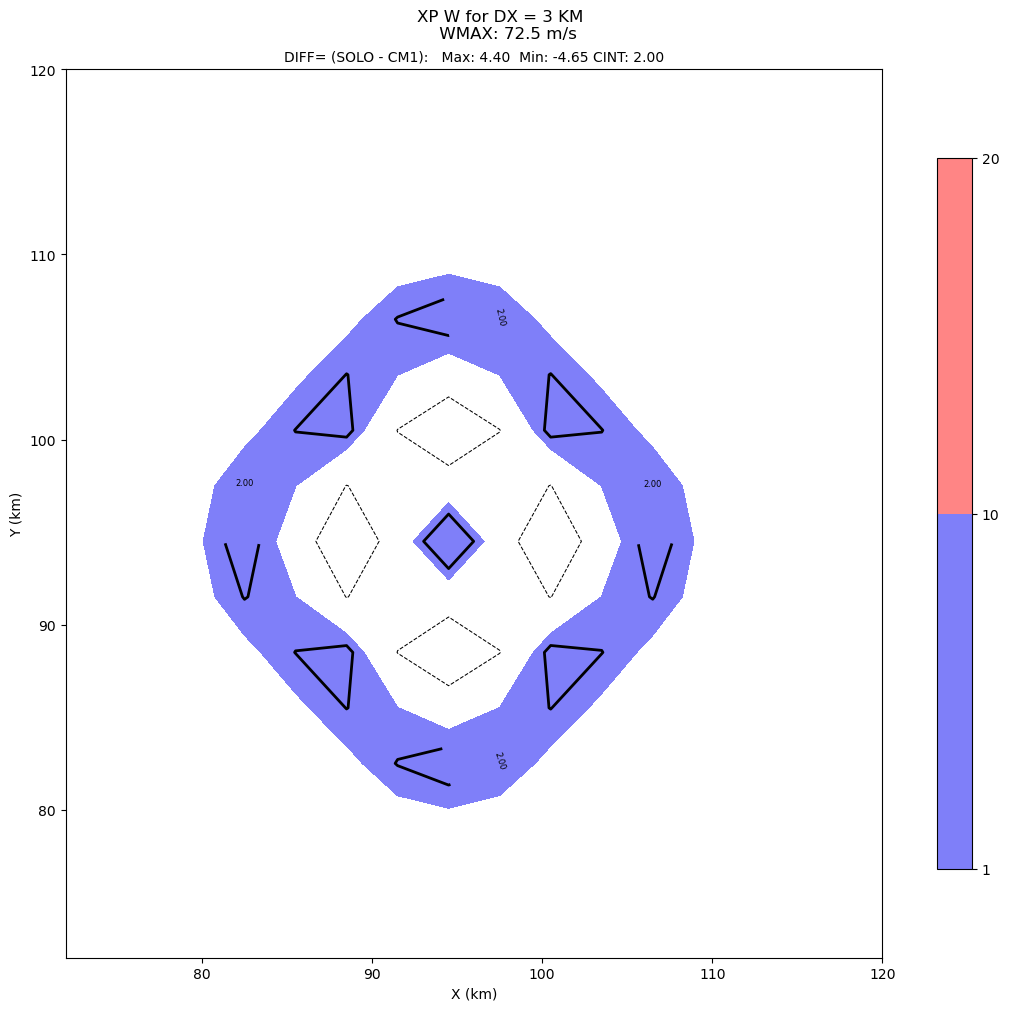

In [35]:
solo = models['solo']
cm1  = models['cm1']

time1 = solo['min'][:]
time2 = cm1['min'][:]
xc    = cm1['xc']/1000.

ny2 = (xc.shape[0]//2) - 1

wlevs = list(-10. + 2.*np.arange(31))

plevs = list(-200. + 50.*np.arange(21))

time1 = solo['min'][:]
time2 = cm1['min'][:]
xc    = cm1['xc']/1000.
yc    = cm1['yc']/1000.

wdiff = solo['w']- cm1['w'][1:]
# wcombo[:,:,32:,32:] = cm1['w'][1,:,32:,32:]

klevel = 25
tlevel = 40

for n in np.arange(10,31,2):

    fields = []
    fields.append(container(wdiff[n+5,:,ny2,:], xc, zlevels/1000.))

    plot_contour_row(fields, plot_type=2, clevels=clevs, color_levels=[1,10,20], 
                     cmap=plt.cm.seismic,
                     suptitle=f"TIME: {time1[+5]} min XZ Cross Section for W \n for DX = 3 KM WMAX: {value} m/s",
                     ptitle=['DIFF= (SOLO - CM1)'], xlabel='X (km)', 
                     ylabel='Z (km)', xlim=(72., 120.), ylim=(0,18.), fancy_lw=True);

value = 72.5

# plot_contour_row(fields, plot_type=2, clevels=clevs, color_levels=[1,10,20], 
#                      cmap=plt.cm.seismic,
#                      suptitle=f"TIME-HEIGHT W for DX = 3 KM  \n WMAX: {value} m/s",
#                      ptitle=['WCOMBO'], xlabel='X (km)', 
#                      ylabel='Z (km)', xlim=(72., 120.), ylim=(0,18.), fancy_lw=True);
klevel = 10

fields = []
fields.append(container(wcombo[tlevel,klevel], xc, yc))
plot_contour_row(fields, plot_type=2, clevels=clevs, color_levels=[1,10,20], 
                     cmap=plt.cm.seismic,
                     suptitle=f"XP W for DX = 3 KM  \n WMAX: {value} m/s",
                     ptitle=['DIFF= (SOLO - CM1)'], xlabel='X (km)', 
                     ylabel='Y (km)', xlim=(72., 120.), ylim=(72., 120.), fancy_lw=True);

#### CROSS Section of 1 KM Squall line init

In [158]:
cm1   = '/work/wicker/climate_runs/cm1r20.3/run/squall/1km/QV16/S06'
solo  = '/work/wicker/climate_runs/FV3_Solo/squall/euler/1km/QV16/S06'

models['cm1']  = ( read_cm1_fields(cm1,  vars = ['pert_th'], zinterp=zlevels, file_pattern=None, ret_dbz=False, ret_ds=False) )
models['solo'] = ( read_solo_fields(solo, vars = ['theta_IC'], zinterp=zlevels, file_pattern=None, ret_dbz=False, ret_ds=False) )


------------------------------------------------------------------------------------------------------------------------ 

 Added default filename to path input:  /work/wicker/climate_runs/cm1r20.3/run/squall/1km/QV16/S06/cm1out.nc
------------------------------------------------------------------------------------------------------------------------ 

 Reading:  /work/wicker/climate_runs/cm1r20.3/run/squall/1km/QV16/S06/cm1out.nc 

 Completed reading in:  /work/wicker/climate_runs/cm1r20.3/run/squall/1km/QV16/S06/cm1out.nc 

------------------------------------------------------------------------------------------------------------------------
 Interpolating fields to single column z-grid:  /work/wicker/climate_runs/cm1r20.3/run/squall/1km/QV16/S06/cm1out.nc 

 Finished interp fields to single column z-grid:  /work/wicker/climate_runs/cm1r20.3/run/squall/1km/QV16/S06/cm1out.nc 

-----------------------------------------------------------------------------------------------------------

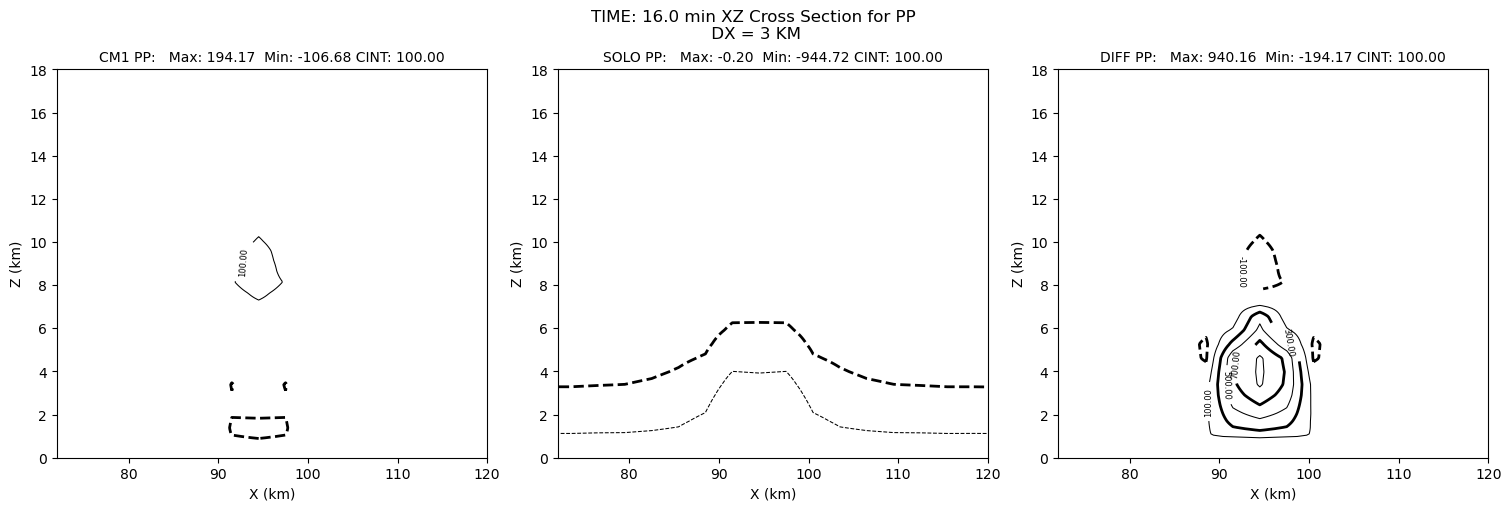

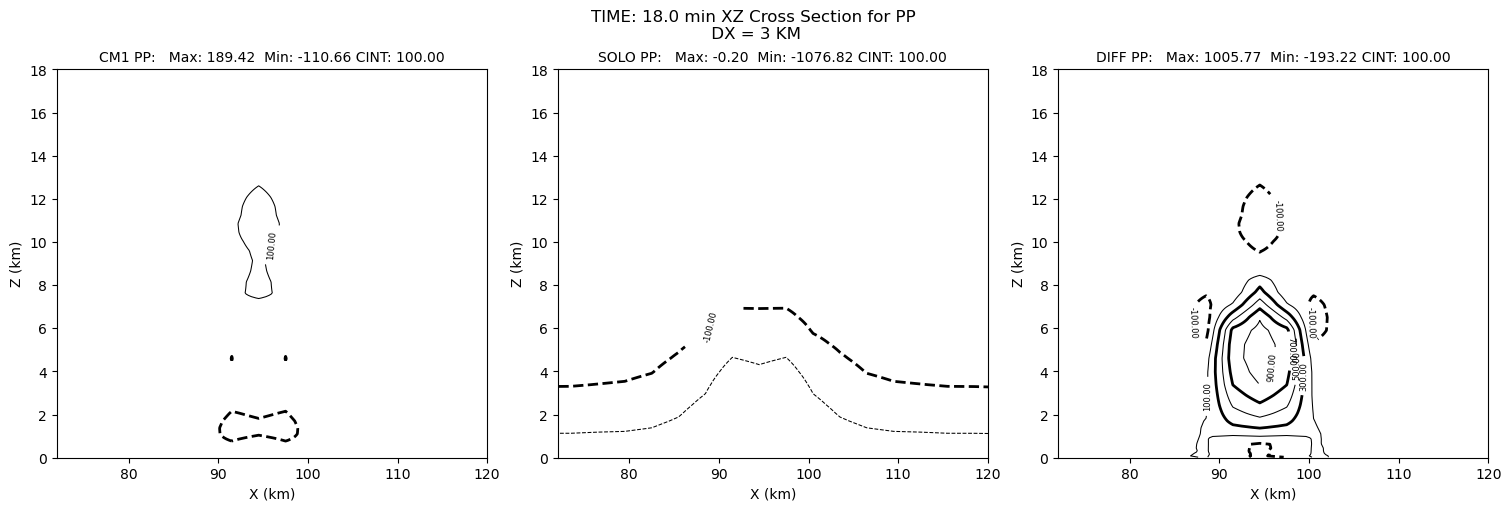

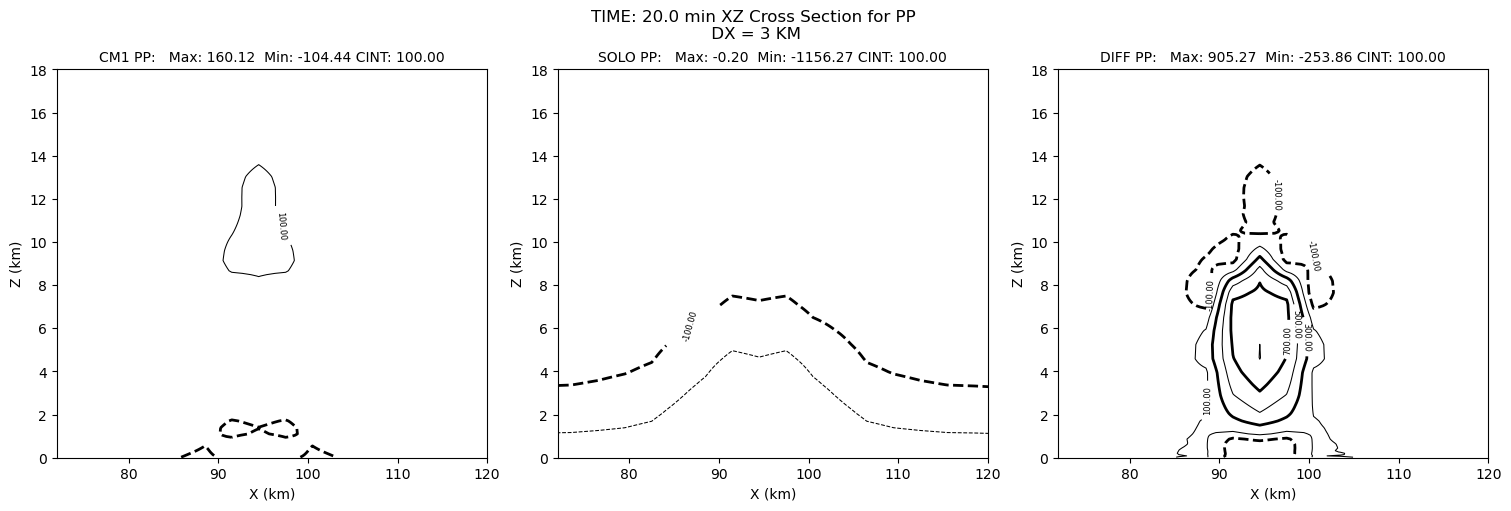

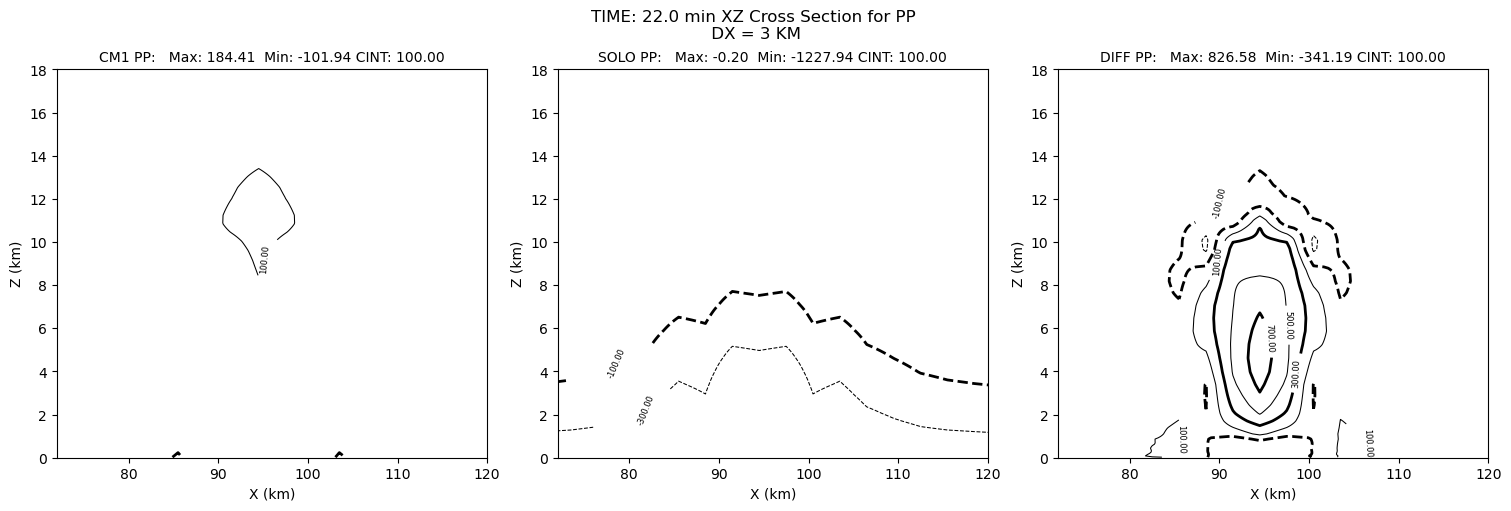

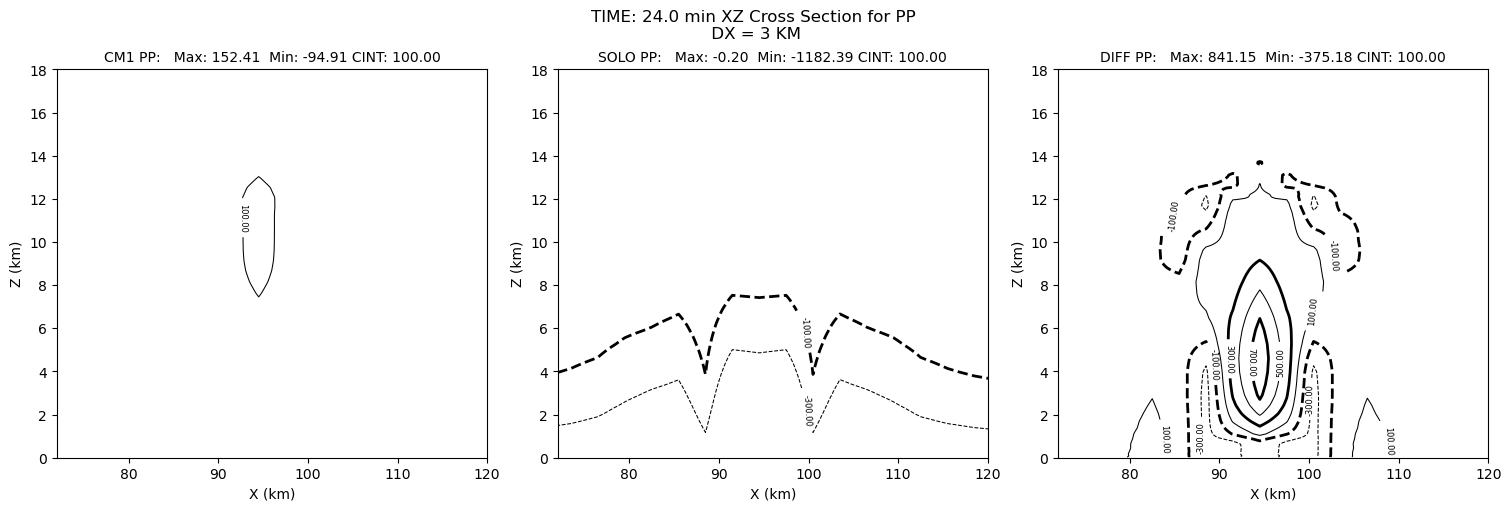

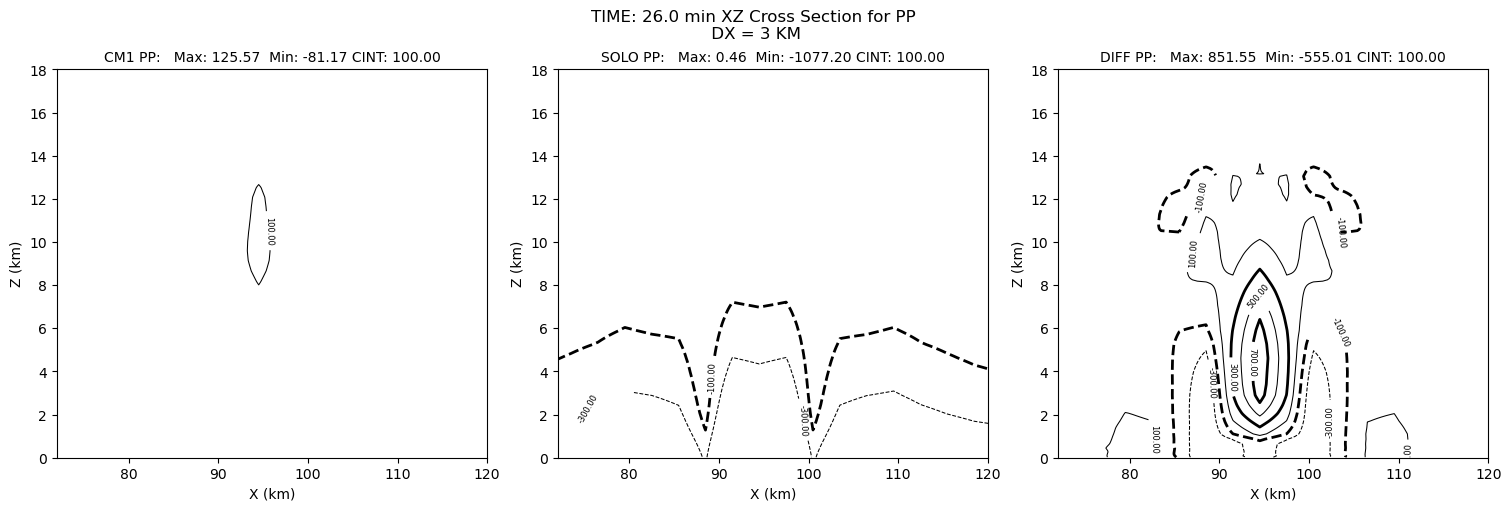

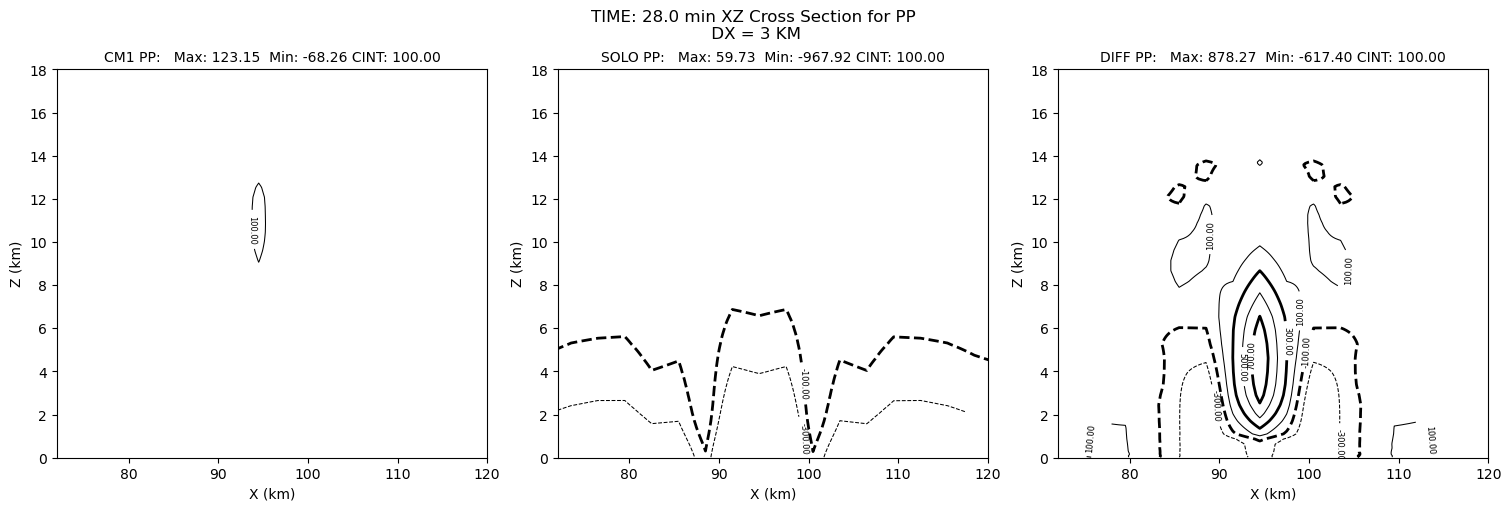

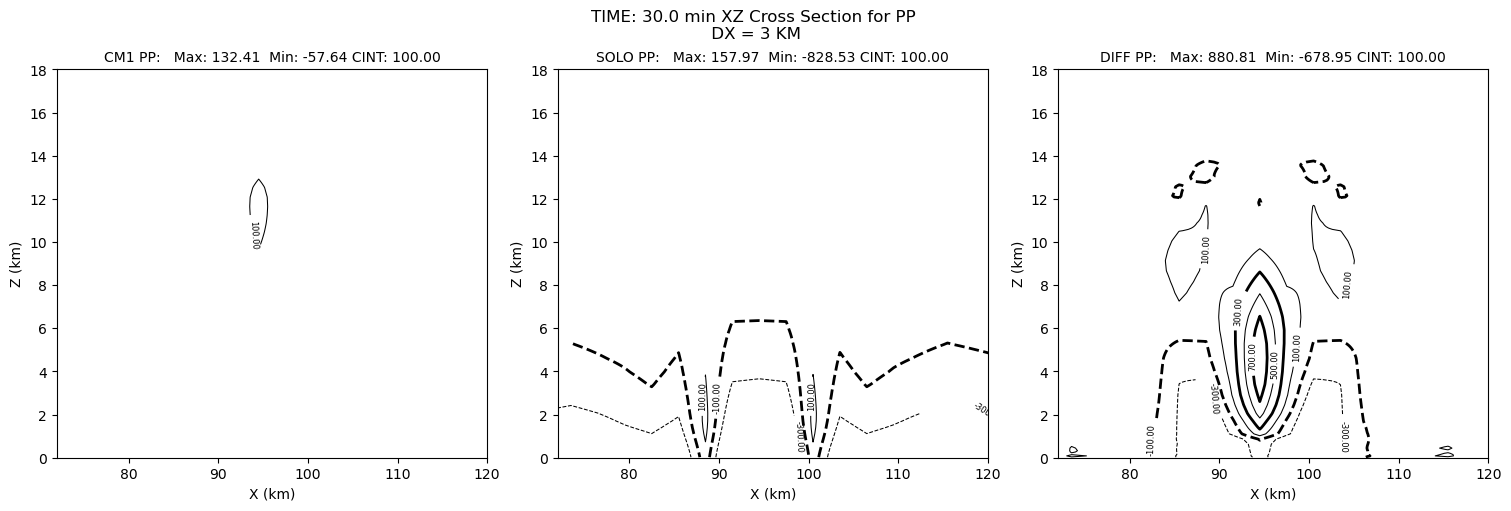

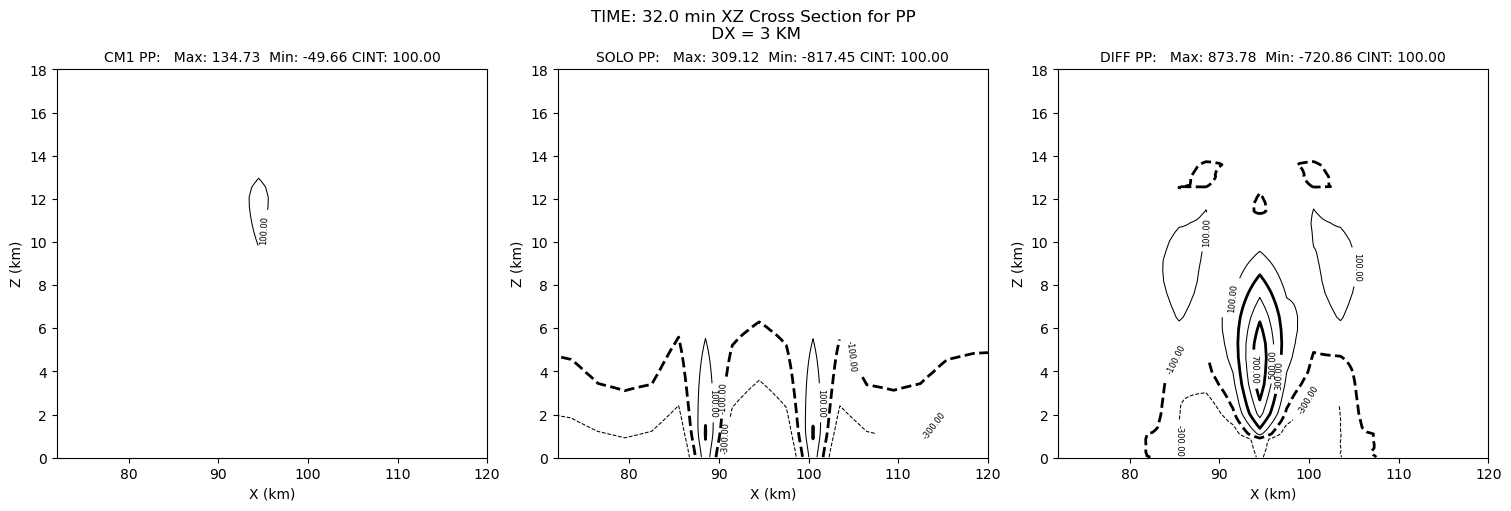

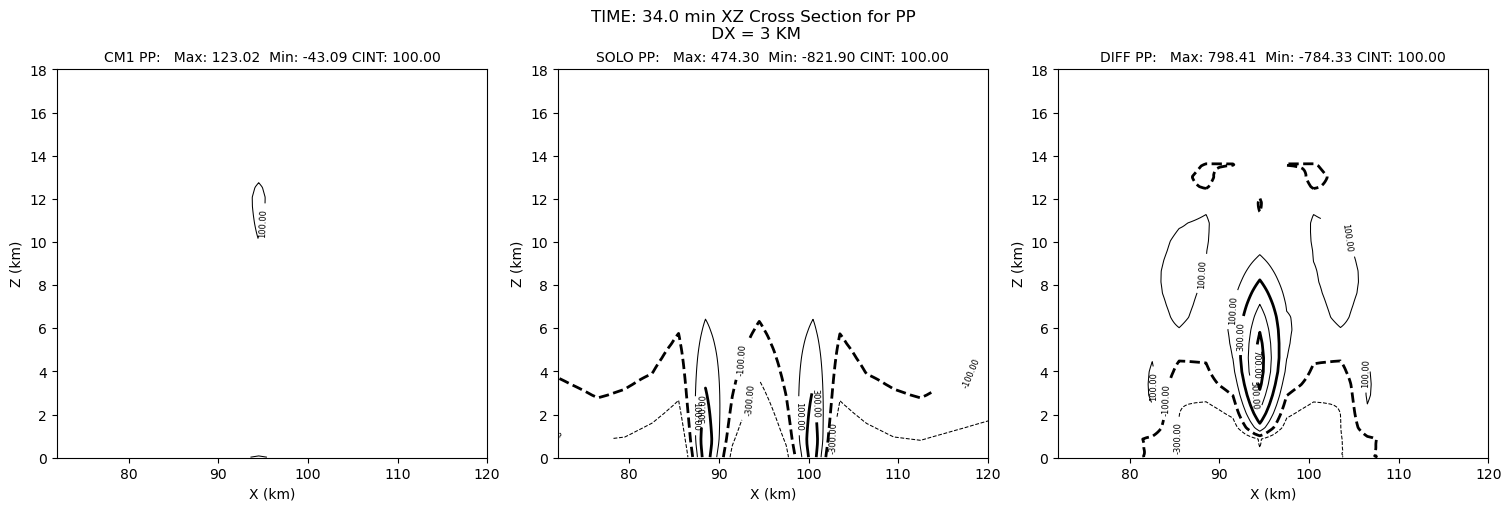

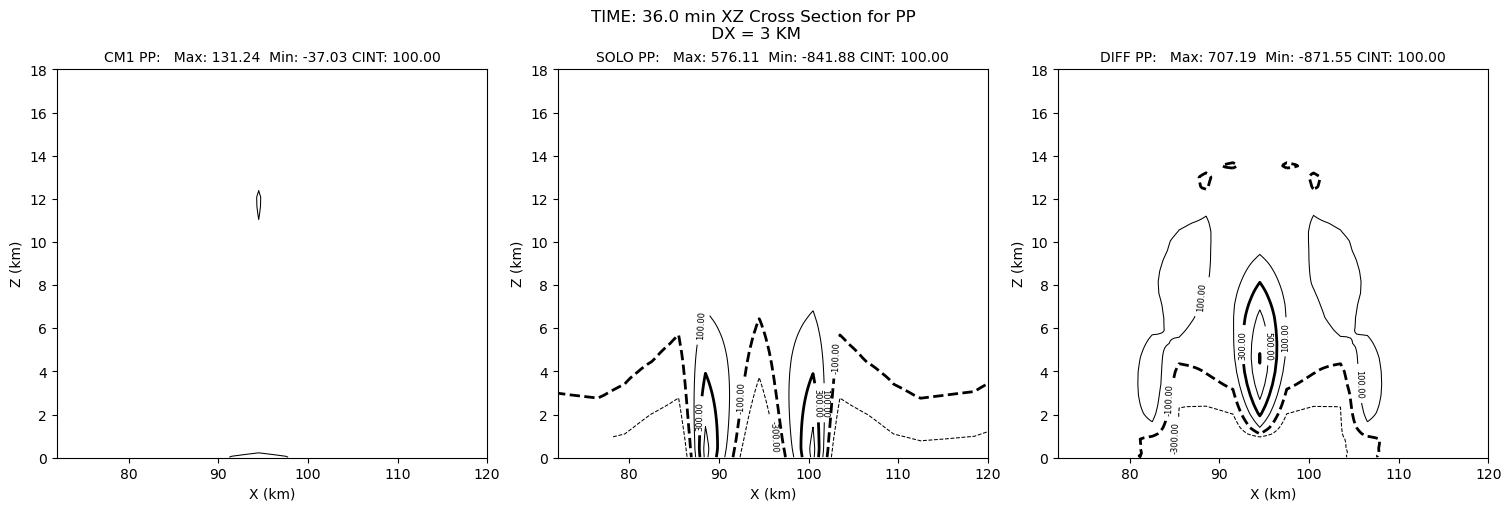

In [51]:
solo = models['solo']
cm1  = models['cm1']

time1 = solo['min'][:]
time2 = cm1['min'][:]
xc    = cm1['xc']/1000.

ny2 = (xc.shape[0]//2) - 1

wlevs = list(-10. + 2.*np.arange(31))

plevs = list(-300. + 100.*np.arange(21))

time1 = solo['min'][:]
time2 = cm1['min'][:]
xc    = cm1['xc']/1000.
yc    = cm1['yc']/1000.

pdiff = solo['pert_p']- cm1['pert_p'][1:]

klevel = 25
tlevel = 40

for n in np.arange(10,31,2):

    fields = []
    fields.append(container(cm1['pert_p'][n+6,:,ny2,:], xc, zlevels/1000.))
    fields.append(container(solo['pert_lucas'][n+5,:,ny2,:], xc, zlevels/1000.))
    fields.append(container(pdiff[n+5,:,ny2,:], xc, zlevels/1000.))

    plot_contour_row(fields, plot_type=1, clevels=plevs, # color_levels=[1,10,20], 
                     cmap=plt.cm.seismic,
                     suptitle=f"TIME: {time1[n+5]} min XZ Cross Section for PP \n DX = 3 KM ",
                     ptitle=['CM1 PP', 'SOLO PP', 'DIFF PP'], xlabel='X (km)', 
                     ylabel='Z (km)', xlim=(72., 120.), ylim=(0,18.), fancy_lw=True);
